Based on the source: 
https://analyticsindiamag.com/how-to-implement-convolutional-autoencoder-in-pytorch-with-cuda/

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import numpy as np
from torchsummary import summary
from datasets import Dataset, Features, Array2D, Value, load_dataset, load_from_disk
from random import randrange


/Users/yijiachen/Desktop/50.021 Artificial Intelligence/Project/code/mazerl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
loaded_data = load_from_disk(
        "/Users/yijiachen/Desktop/50.021 Artificial Intelligence/Project/code/code-repo/Auto-encoder/autoencoder_21x21_train.hf"
    ).with_format("torch")

print(loaded_data.shape)
print(loaded_data[0]['maze'].float())
print(loaded_data[0]['groundtruth'].float())

(30000, 2)
tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
         0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.,
         0.],
        [0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1.,
         0.],
        [0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
         0.],
        [0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
         0.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
         0.],
        [1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
         0.],
        [0., 1., 0., 0., 0., 1., 0., 0.

In [6]:
    
class ConvAutoencoder(nn.Module):
    def __init__(self):
        #----------------------------------------
        # Define the Neural Network Architecture
        #----------------------------------------
        
        super(ConvAutoencoder, self).__init__()
        #Encoder
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=2, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=2, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
        self.pool = nn.AvgPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, output_padding=0)
        self.t_conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, output_padding=0)
        self.t_conv3 = nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=2, stride=1, output_padding=0)
        self.t_conv4 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=2, stride=1, output_padding=0)

    #----------------------------------------
    # Define the Neural Network
    #----------------------------------------
    def forward(self, x):
        out1 = F.gelu(self.conv1(x))
        # x = self.pool(x)
        x = F.gelu(self.conv2(out1))
        # x = self.pool(x)
        x = F.gelu(self.conv3(x))
        x = F.gelu(self.conv4(x))
        # x = self.pool(x)
        x = F.gelu(self.t_conv1(x))        
        x = F.gelu(self.t_conv2(x))
        x = F.gelu(self.t_conv3(x)+out1)
        x = F.sigmoid(self.t_conv4(x))
        return x

#Instantiate the model
model = ConvAutoencoder()
n = 19
summary(model, (1,n,n))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 18, 18]              40
            Conv2d-2           [-1, 32, 17, 17]           1,056
            Conv2d-3           [-1, 64, 15, 15]          18,496
            Conv2d-4          [-1, 128, 13, 13]          73,856
   ConvTranspose2d-5           [-1, 64, 15, 15]          73,792
   ConvTranspose2d-6           [-1, 32, 17, 17]          18,464
   ConvTranspose2d-7            [-1, 8, 18, 18]           1,032
   ConvTranspose2d-8            [-1, 1, 19, 19]              33
Total params: 186,769
Trainable params: 186,769
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.57
Params size (MB): 0.71
Estimated Total Size (MB): 1.28
----------------------------------------------------------------


In [7]:
#----------------------------------------
# Heuristic algorithm to draw given starting coordinate, the direction to take
# and number of steps to take. Each time the move function is called, it
# assigns a value inside the matrix image for coordinates calculated.
#----------------------------------------

def move(i,j,n,direction,step,t,v):
    if direction==0 and j+step<=n-1:#right
        for k in range(0,step):
            j=j+1
            t[i][j]=v 
    elif direction==1 and j-step>=0:#left
        for k in range(0,step):
            j=j-1
            t[i][j]=v
    elif direction==2 and i-step>=0:#up
        for k in range(0,step):
            i=i-1
            t[i][j]=v
    elif direction==3 and i+step<=n-1:#down
        for k in range(0,step):
            i=i+1
            t[i][j]=v
    return i,j

#----------------------------------------
# A helper function that checks if there is any path in its way of moving.
# The function often helps at creating cycles inside the maze problem.
#----------------------------------------
def inrange(i,j,direction,t):
    if direction==0 and (t[i+1][j]==0 or t[i][j+1]==0 or t[i-1][j]==0):
        return True
    elif direction==1 and (t[i+1][j]==0 or t[i][j-1]==0 or t[i-1][j]==0):
        return True
    elif direction==2 and (t[i][j-1]==0 or t[i+1][j]==0 or t[i][j+1]==0):
        return True
    elif direction==3 and (t[i][j-1]==0 or t[i-1][j]==0 or t[i][j+1]==0):
        return True
    return False

def generate_Solution(i,j,n,solution):    
#----------------------------------------
# Create the Solution First: 1 x n x n
# the solution is also known as the target image where
# the neural net will use to learn from in the training
#----------------------------------------
    solution[i][j]=0
    while (i!=0 or j!=n-1):
        direction=random.choice([0,2])
        step=random.choice([1,1,2,3])
        i,j=move(i,j,n,direction,step,solution,0)
    return solution

def generate_Problem(i,j,n,problem):
#---------------------------------------------------
# Create the Problem Based on Solution: 1 x n x n
# the problem is also known as the input image where 
# the neural net will take as input while training
#---------------------------------------------------
    branchcount=random.randint(3,4)
    branchcoords=random.sample(range(0, n-1,2),branchcount)
    for coord in branchcoords:
        for y in range(n-1):
            if problem[y][coord]==0:
                i=y
                j=coord
                alternative=random.randint(0,1)#left up if 0, right down if 1
                #start drawing line
                while ((0<i and i<n-1 and j!=0) or (0<j and j<n-1 and i!=0)):
                    if alternative==1:
                        direction=random.choice([1,2])
                    else:
                        direction=random.choice([0,3])
                    step=random.choice([1,1,2,3])
                    i,j=move(i,j,n,direction,step,problem,0)
                break
    for coords in branchcoords:
        for x in range(n-1):
            if problem[coord][x]==0:
                i=coord
                j=x
                alternative=random.randint(0,1)#left up if 0, right down if 1
                #start drawing line
                while ((0<i and i<n-1 and j!=0) or (0<j and j<n-1 and i!=0) and (not inrange(i,j,direction,problem))):
                    if alternative==1:
                        direction=random.choice([0,2])
                    else:
                        direction=random.choice([1,3])
                    step=random.choice([1,1,2,3])
                    i,j=move(i,j,n,direction,step,problem,0)
                break
    return problem

In [8]:
n=19
m=10000
#-----------------------------------------------------------------
# Create 10000 x 1 x 8 x 8 training input and target pairs
#-----------------------------------------------------------------
mazes = torch.zeros(m,1,n,n)
sols = torch.zeros(m,1,n,n)
for k in range(m):
    solution = torch.ones(n,n)
    problem = torch.ones(n,n)
    i,j=n-1,0
    # solution=generate_Solution(i,j,n,solution)
    solution = loaded_data[k]['groundtruth'].float()
    i,j=n-1,0
    # problem=generate_Problem(i,j,n,solution.clone())
    problem = loaded_data[k]['maze'].float()

    mazes[k,0]=problem
    sols[k,0]=solution

#load data
dataset = torch.utils.data.TensorDataset(mazes, sols)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, num_workers=0)

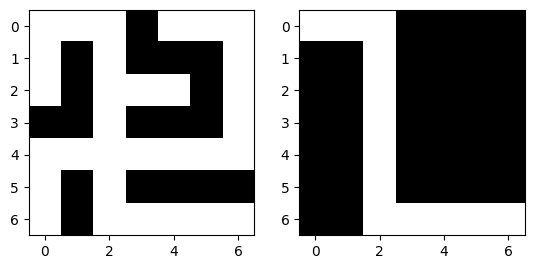

In [41]:
testMaze=torch.ones(1,n,n)
testSol=torch.ones(n,n) 

testSol=loaded_data[0]['groundtruth'].float()
testMaze[0] = loaded_data[0]['maze'].float()

fig, axes = plt.subplots(1,2)
axes[0].imshow(testMaze[0,:,:],cmap='binary')
axes[1].imshow(testSol,cmap='binary')




In [12]:
testSol

# 1s meaning the black, 0s are the white, path of the solution

tensor([[0., 0., 0., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0., 0., 0.]])

cpu
Epoch: 1 	Training Loss: 8.585173


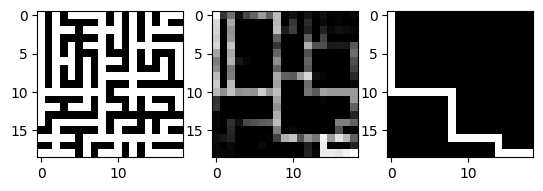

Epoch: 2 	Training Loss: 8.224575


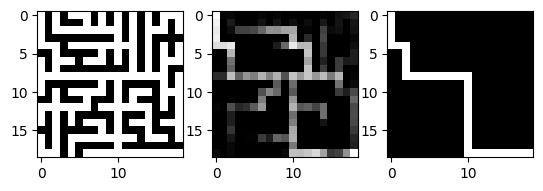

Epoch: 3 	Training Loss: 7.947853


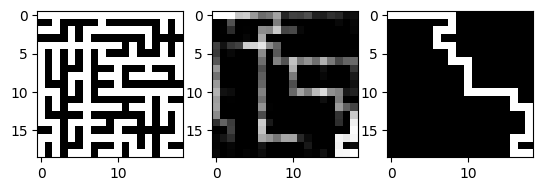

Epoch: 4 	Training Loss: 7.745947


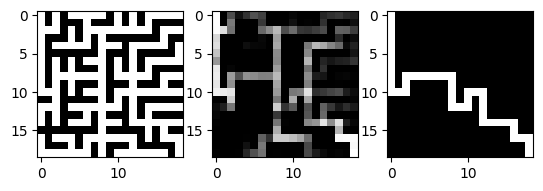

Epoch: 5 	Training Loss: 7.576401


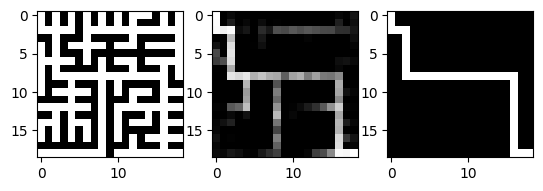

Epoch: 6 	Training Loss: 7.412408


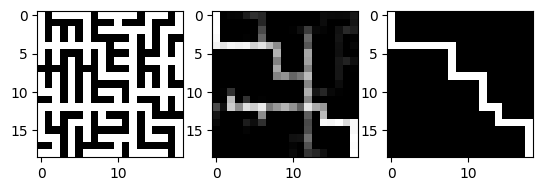

Epoch: 7 	Training Loss: 7.270031


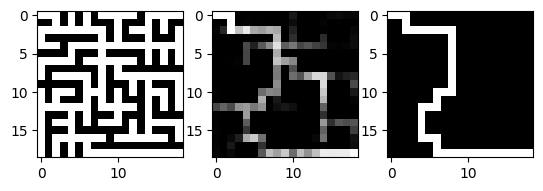

Epoch: 8 	Training Loss: 7.153091


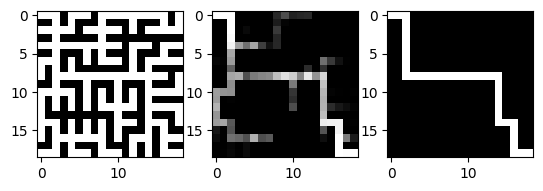

Epoch: 9 	Training Loss: 7.072519


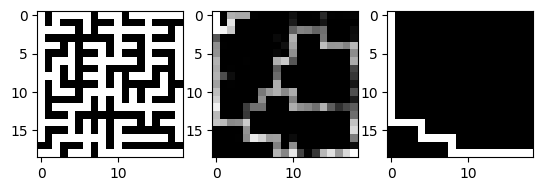

Epoch: 10 	Training Loss: 7.019709


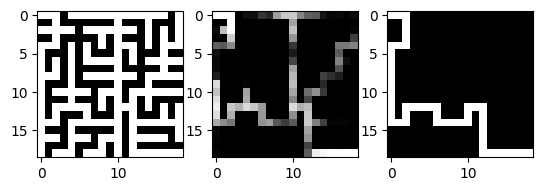

Epoch: 11 	Training Loss: 6.933676


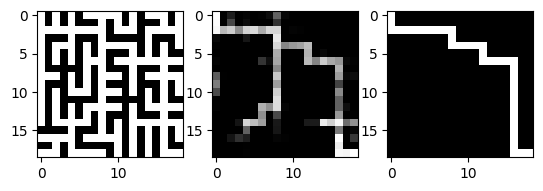

Epoch: 12 	Training Loss: 6.806901


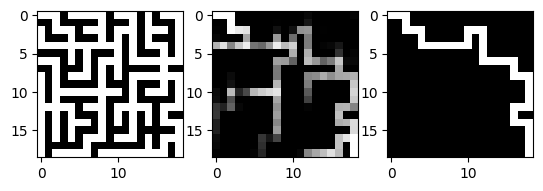

Epoch: 13 	Training Loss: 6.718911


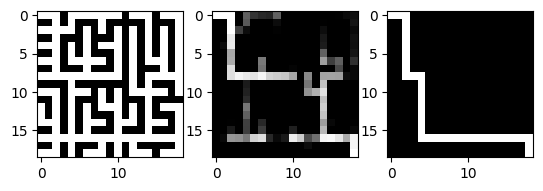

Epoch: 14 	Training Loss: 6.658064


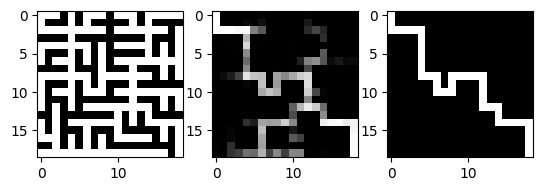

Epoch: 15 	Training Loss: 6.550529


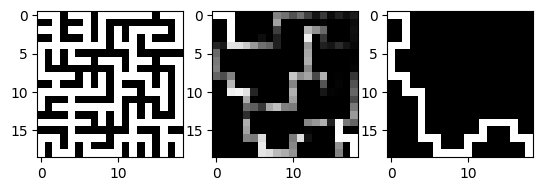

Epoch: 16 	Training Loss: 6.439999


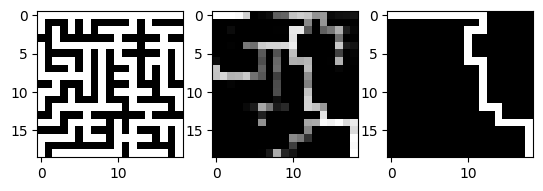

Epoch: 17 	Training Loss: 6.340093


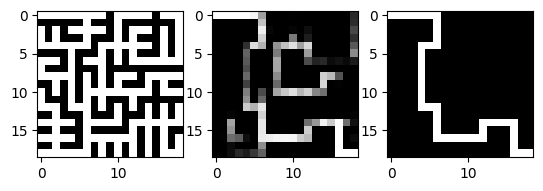

Epoch: 18 	Training Loss: 6.255932


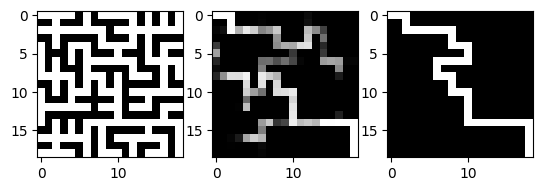

Epoch: 19 	Training Loss: 6.195012


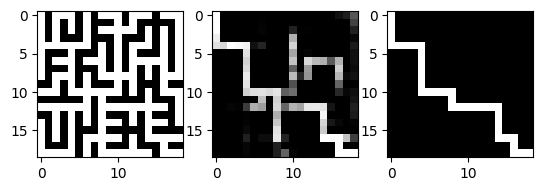

Epoch: 20 	Training Loss: 6.156863


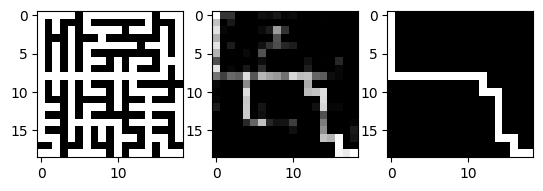

Epoch: 21 	Training Loss: 6.111689


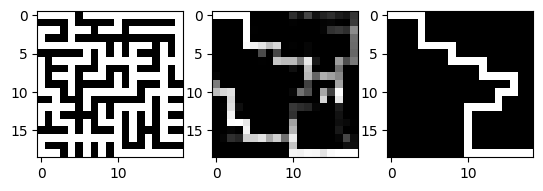

Epoch: 22 	Training Loss: 6.051343


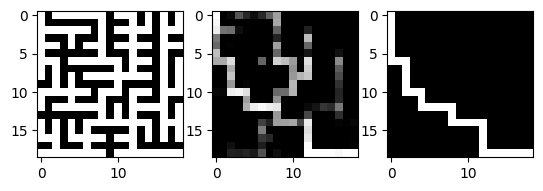

Epoch: 23 	Training Loss: 6.001545


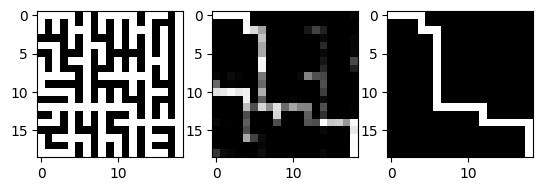

Epoch: 24 	Training Loss: 6.012014


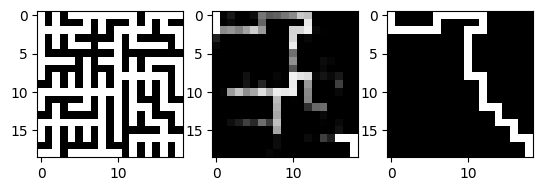

Epoch: 25 	Training Loss: 6.008684


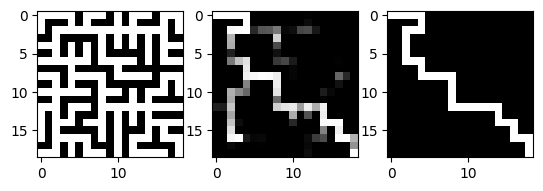

Epoch: 26 	Training Loss: 5.925134


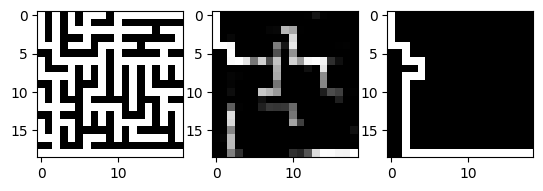

Epoch: 27 	Training Loss: 5.815723


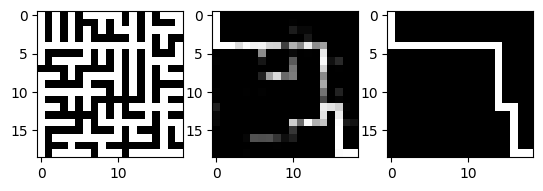

Epoch: 28 	Training Loss: 5.723837


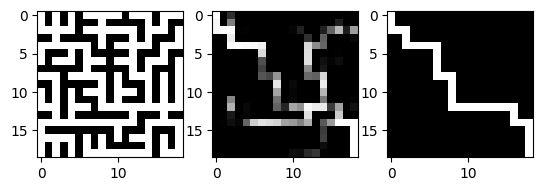

Epoch: 29 	Training Loss: 5.662144


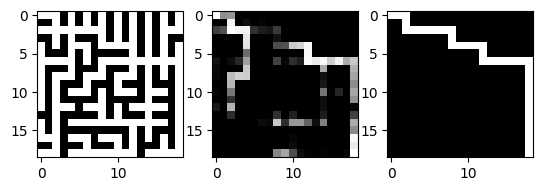

Epoch: 30 	Training Loss: 5.623090


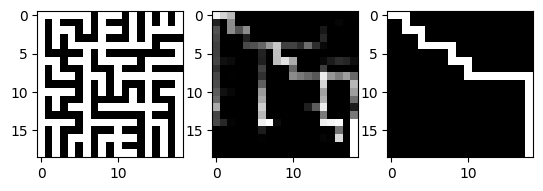

Epoch: 31 	Training Loss: 5.607762


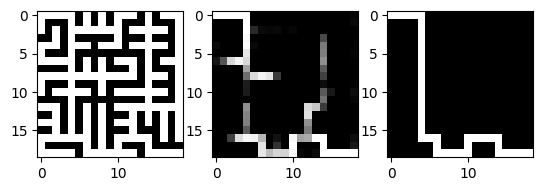

Epoch: 32 	Training Loss: 5.589877


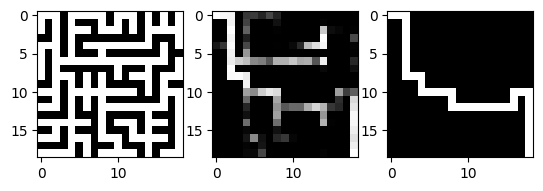

Epoch: 33 	Training Loss: 5.547080


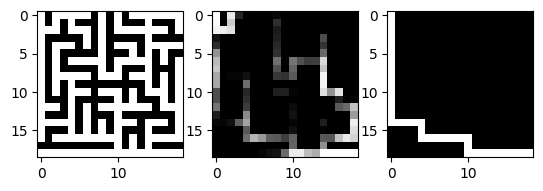

Epoch: 34 	Training Loss: 5.471734


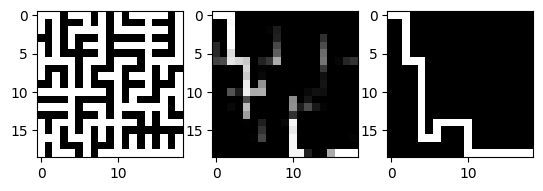

Epoch: 35 	Training Loss: 5.410757


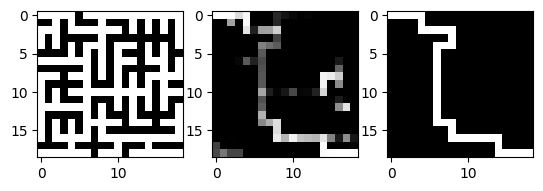

Epoch: 36 	Training Loss: 5.334607


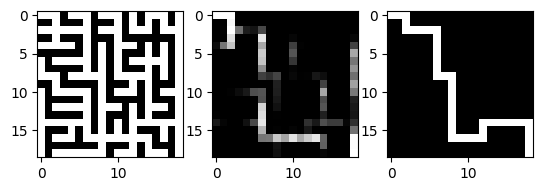

Epoch: 37 	Training Loss: 5.243525


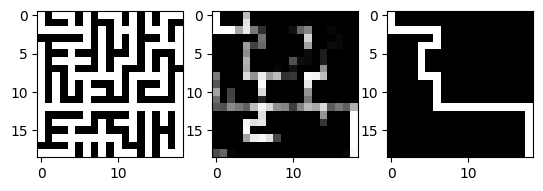

Epoch: 38 	Training Loss: 5.155272


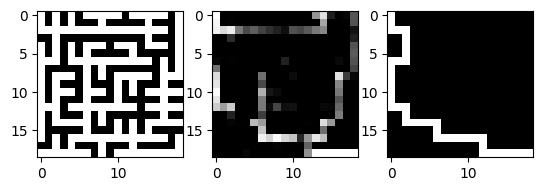

Epoch: 39 	Training Loss: 5.075946


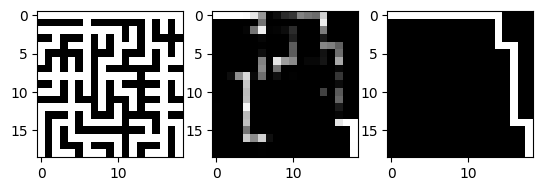

Epoch: 40 	Training Loss: 5.019983


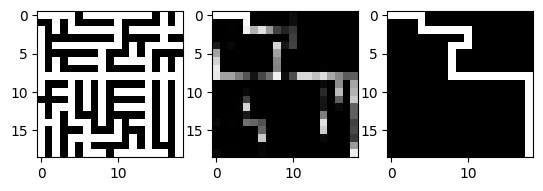

Epoch: 41 	Training Loss: 4.993204


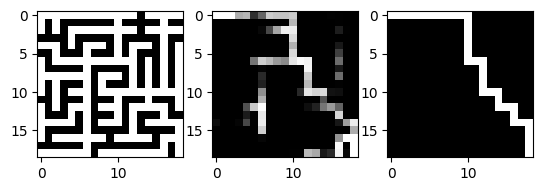

Epoch: 42 	Training Loss: 5.002958


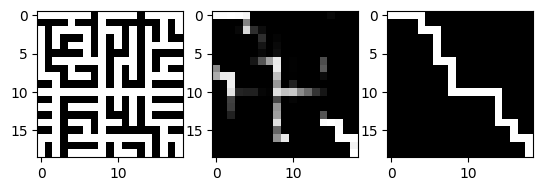

Epoch: 43 	Training Loss: 5.031066


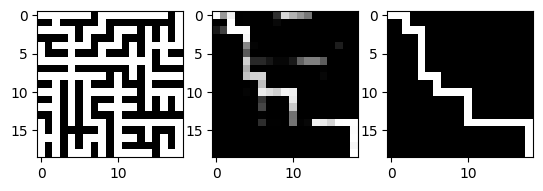

Epoch: 44 	Training Loss: 5.032066


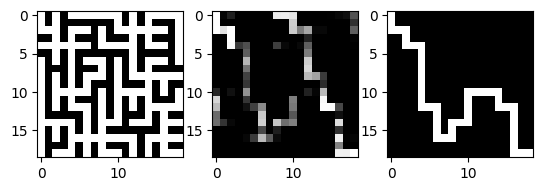

Epoch: 45 	Training Loss: 5.007122


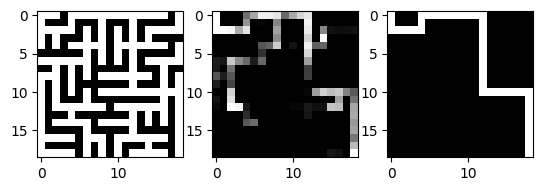

Epoch: 46 	Training Loss: 4.991706


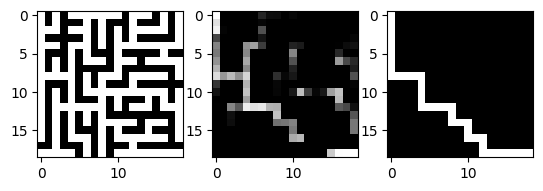

Epoch: 47 	Training Loss: 4.997583


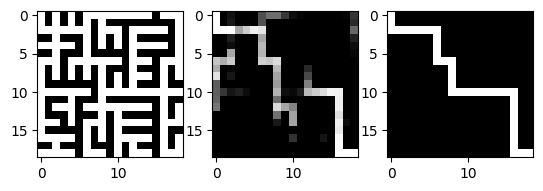

Epoch: 48 	Training Loss: 5.015526


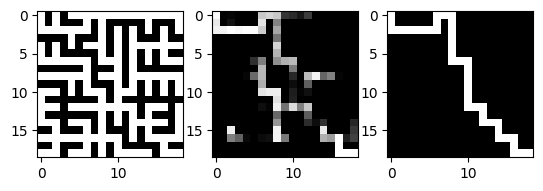

Epoch: 49 	Training Loss: 4.990919


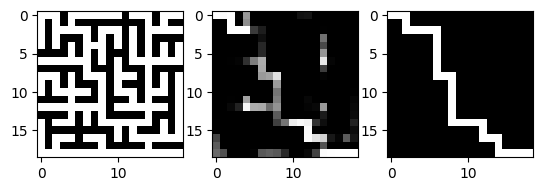

Epoch: 50 	Training Loss: 4.889821


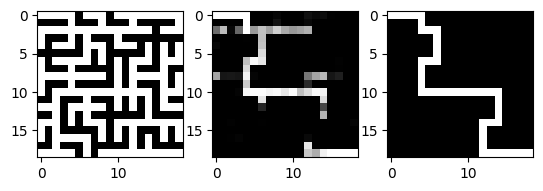

Epoch: 51 	Training Loss: 4.767438


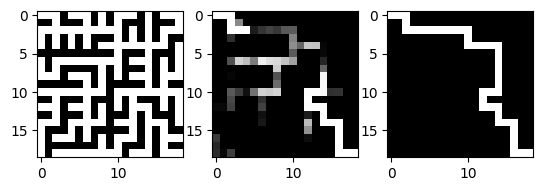

Epoch: 52 	Training Loss: 4.656154


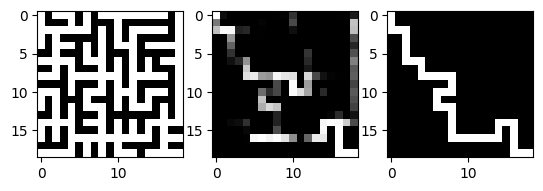

Epoch: 53 	Training Loss: 4.561092


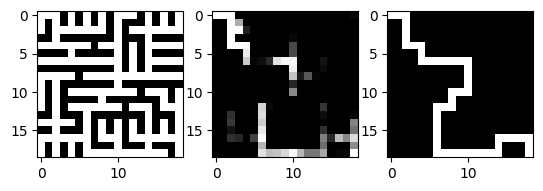

Epoch: 54 	Training Loss: 4.480845


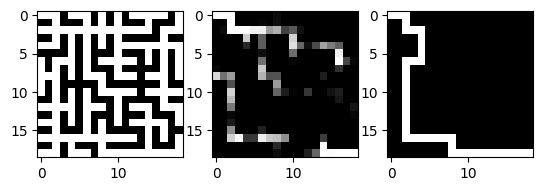

Epoch: 55 	Training Loss: 4.415092


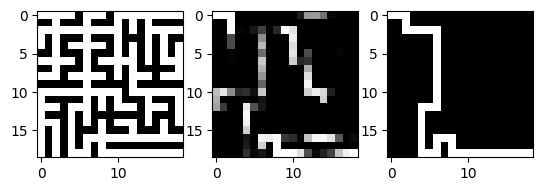

Epoch: 56 	Training Loss: 4.375173


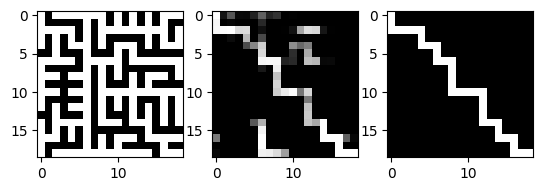

Epoch: 57 	Training Loss: 4.356807


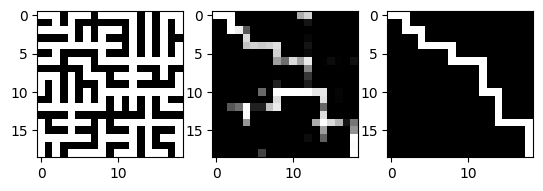

Epoch: 58 	Training Loss: 4.380572


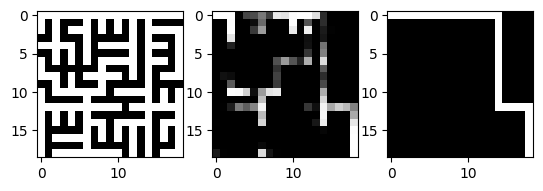

Epoch: 59 	Training Loss: 4.520002


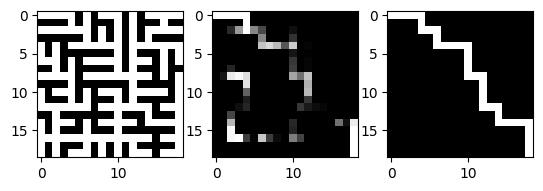

Epoch: 60 	Training Loss: 4.674653


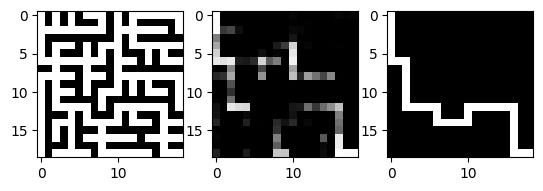

Epoch: 61 	Training Loss: 4.614635


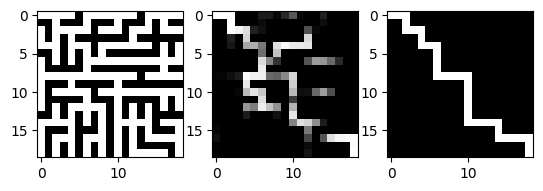

Epoch: 62 	Training Loss: 4.444358


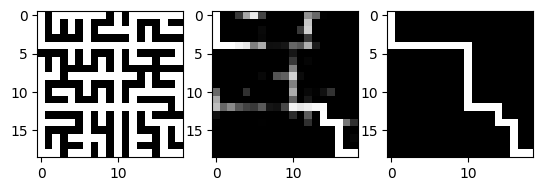

Epoch: 63 	Training Loss: 4.312805


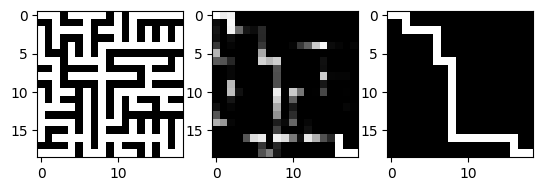

Epoch: 64 	Training Loss: 4.210393


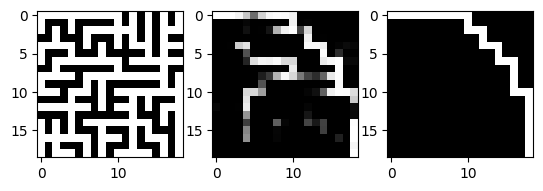

Epoch: 65 	Training Loss: 4.132166


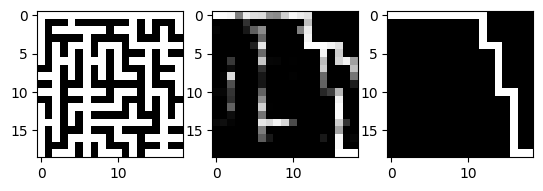

Epoch: 66 	Training Loss: 4.073722


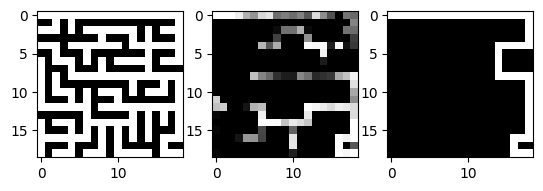

Epoch: 67 	Training Loss: 4.029151


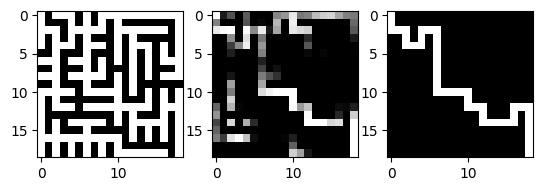

Epoch: 68 	Training Loss: 4.009441


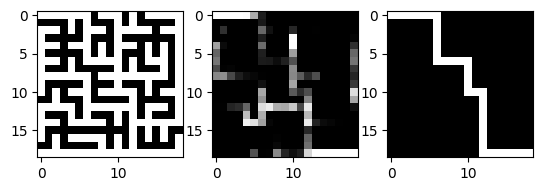

Epoch: 69 	Training Loss: 4.010387


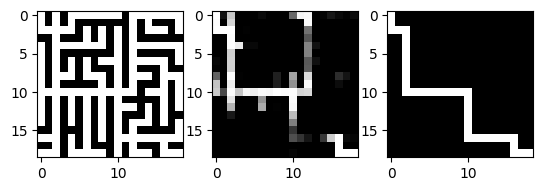

Epoch: 70 	Training Loss: 4.067556


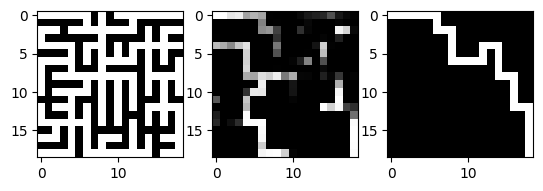

Epoch: 71 	Training Loss: 4.200113


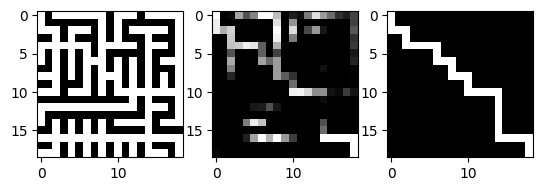

Epoch: 72 	Training Loss: 4.375504


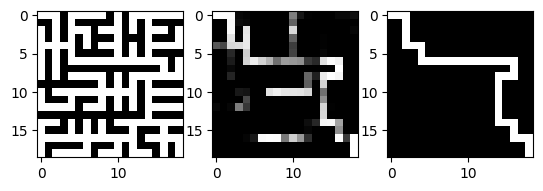

Epoch: 73 	Training Loss: 4.328936


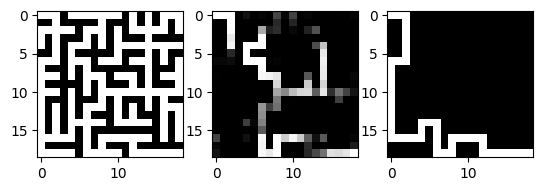

Epoch: 74 	Training Loss: 4.170000


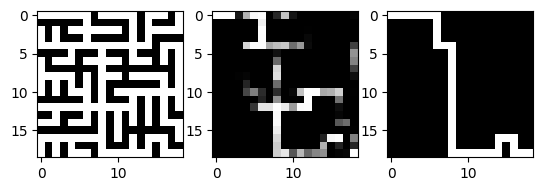

Epoch: 75 	Training Loss: 3.994123


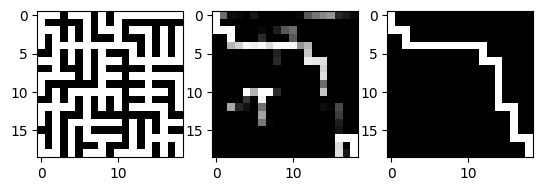

Epoch: 76 	Training Loss: 3.853505


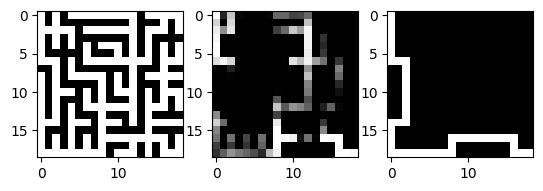

Epoch: 77 	Training Loss: 3.748359


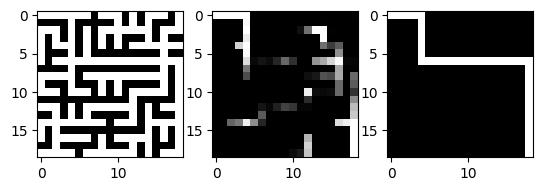

Epoch: 78 	Training Loss: 3.666482


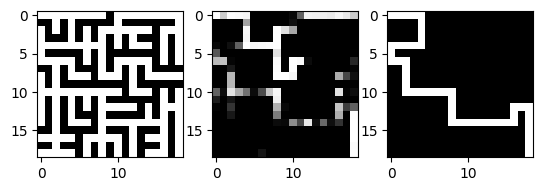

Epoch: 79 	Training Loss: 3.621431


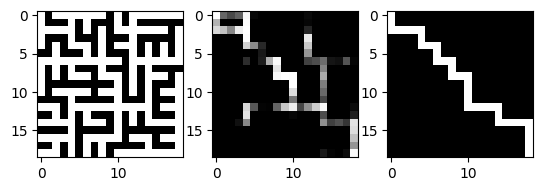

Epoch: 80 	Training Loss: 3.593044


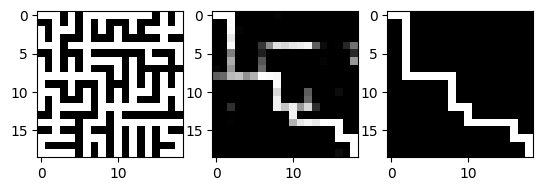

Epoch: 81 	Training Loss: 3.595365


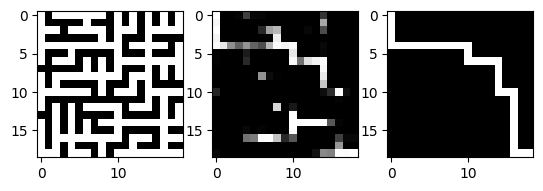

Epoch: 82 	Training Loss: 3.622576


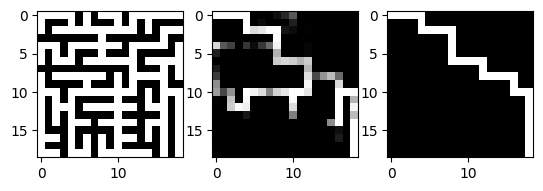

Epoch: 83 	Training Loss: 3.680387


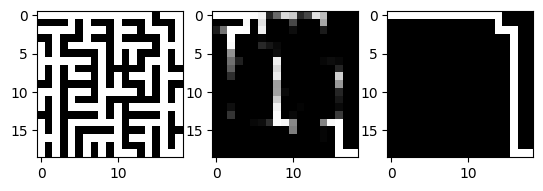

Epoch: 84 	Training Loss: 3.845066


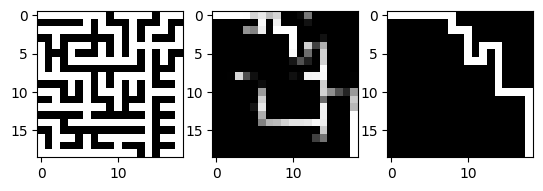

Epoch: 85 	Training Loss: 3.958014


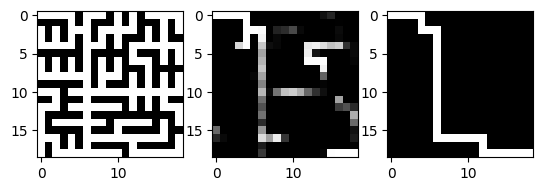

Epoch: 86 	Training Loss: 3.910700


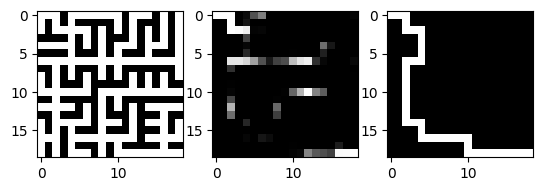

Epoch: 87 	Training Loss: 3.764068


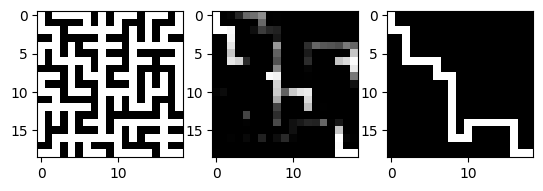

Epoch: 88 	Training Loss: 3.610173


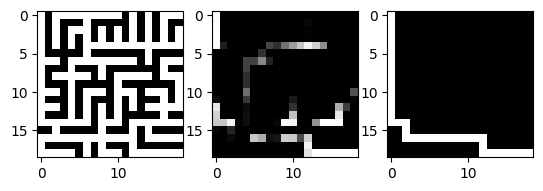

Epoch: 89 	Training Loss: 3.505762


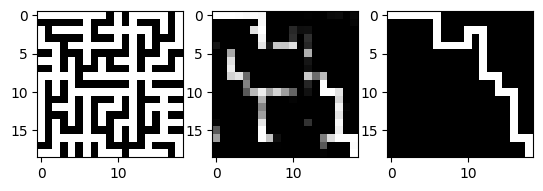

Epoch: 90 	Training Loss: 3.436581


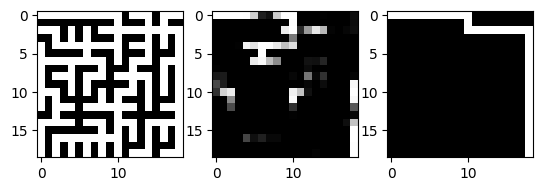

Epoch: 91 	Training Loss: 3.406625


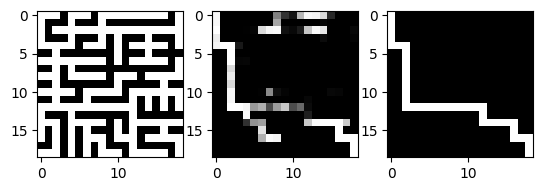

Epoch: 92 	Training Loss: 3.413172


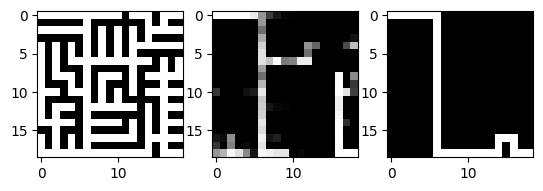

Epoch: 93 	Training Loss: 3.445844


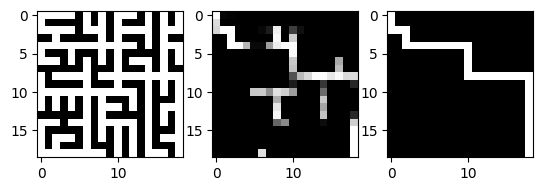

Epoch: 94 	Training Loss: 3.503721


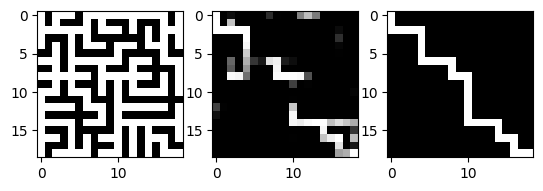

Epoch: 95 	Training Loss: 3.594593


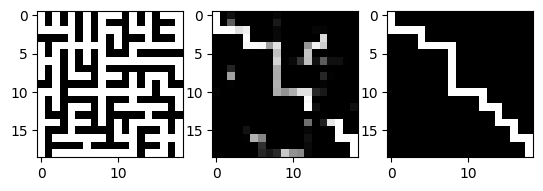

Epoch: 96 	Training Loss: 3.688639


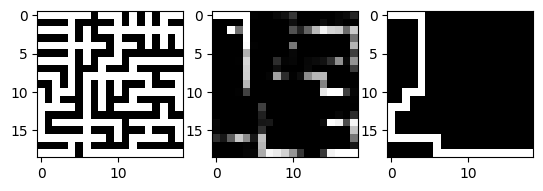

Epoch: 97 	Training Loss: 3.698981


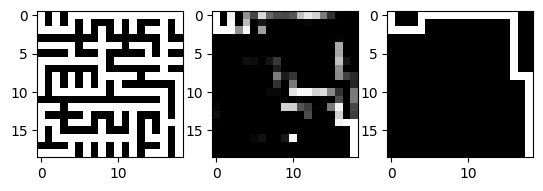

Epoch: 98 	Training Loss: 3.575507


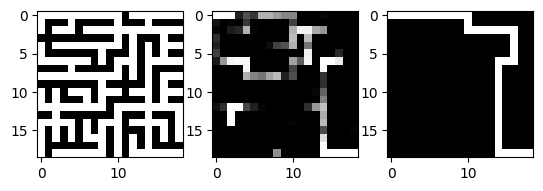

Epoch: 99 	Training Loss: 3.433145


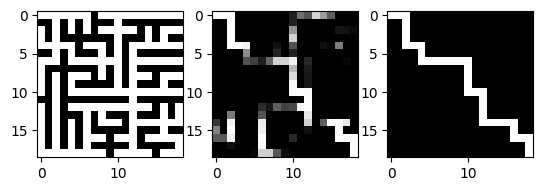

Epoch: 100 	Training Loss: 3.307169


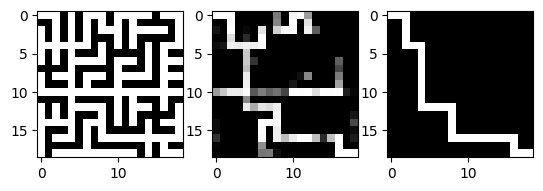

In [14]:
#Loss function
criterion = nn.BCELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#--------------
# Testing
#--------------

def testModel():
    testMaze=torch.ones(1,n,n)
    testSol=torch.ones(n,n) 

    random_datapoint = random.randint(20000, 29999)
    testSol=loaded_data[random_datapoint]['groundtruth'].float()
    testMaze[0] = loaded_data[random_datapoint]['maze'].float()
    #testMaze = testMaze.to(device)
    with torch.no_grad():
        testSolved = model(testMaze).numpy()

    fig, axes = plt.subplots(1,3)
    axes[0].imshow(testMaze[0,:,:],cmap='binary')
    axes[1].imshow(testSolved[0,:,:],cmap='binary')
    axes[2].imshow(testSol,cmap='binary')
    
    plt.show()

#----------------------------
# Set Device
# and transfer the inputs to
# the device
#----------------------------

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
#device = 'mps'
print(device)
model.to(device)

#--------------
# Training
#--------------

epochs = 100
lossList=[]
epochList=[]
for epoch in range(1, epochs+1):
    # monitor training loss
    trainLoss = 0.0
    for images, targets in dataloader:
        # images are mazes with noise
        # targets are mazes without noise
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        targets = targets.to(device)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        trainLoss += loss.item()*images.size(0)
          
    trainLoss = trainLoss/len(dataloader)
    lossList.append(trainLoss)
    epochList.append(epochs)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, trainLoss))
    testModel()

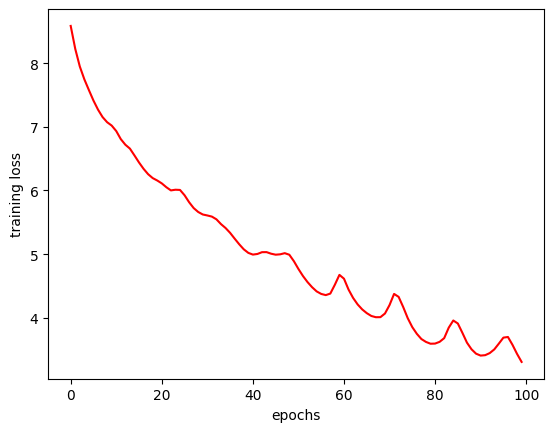

In [15]:
#----------------------------
# Loss vs Epoch graph
#----------------------------
plt.xlabel("epochs")
plt.ylabel("training loss")
plt.plot(lossList,color='red')
plt.show()

In [ ]:
PATH = './AE_21x21.pth'
torch.save(model.state_dict(), PATH)

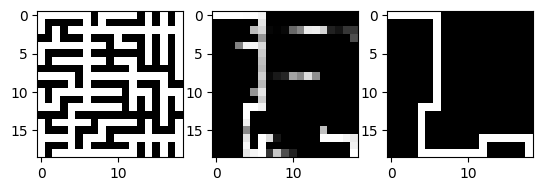

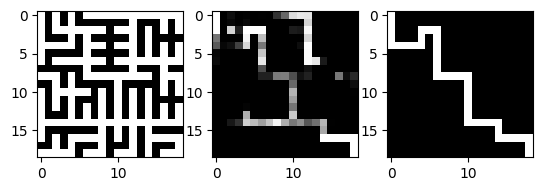

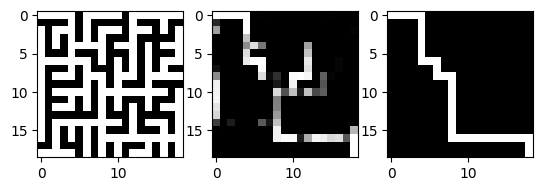

In [17]:
#----------------------------
# Testing is done for 3 images
#----------------------------

for i in range(3):
    testModel()